In [ ]:
%reset -f
import sys
sys.path.insert(0,'..')
from wavhandler import *
import os, glob
import pandas as pd
from configs import *
from sklearn.model_selection import train_test_split
from utils_train import *
from sklearn.preprocessing import LabelEncoder

### data collecting

In [ ]:
mebios = DatasetConfiguration(names=['Mebios_RL'])
mebios.select_all(); 
mebios.read();
mebios.df.labels.value_counts()

In [ ]:
rodr = DatasetConfiguration(names=['Rodrigo'])
rodr.select_all();
rodr.read()
rodr.df.labels = rodr.df.labels.apply(lambda x: f'{x.replace(" ", "")}_')
rodr.df.labels.value_counts()

In [ ]:
pcfruit49 = DatasetConfiguration(names=['Pcfruit_sensor49'])
pcfruit49.select_all();
pcfruit49.read()
pcfruit49.df.labels = pcfruit49.df.labels.apply(lambda x: f'{x}_')
pcfruit49.df.labels.value_counts()

## train

In [5]:
train_meb = mebios.df[mebios.df.labels.isin(['D.melanogasterL','D.suzukiiL'])]
train_rodr = rodr.df.copy()
train = pd.concat([train_meb, train_rodr])
train.labels = train.labels.apply(lambda x: x[:-1])
train.labels.value_counts()

D.suzukii         23038
D.melanogaster     9605
Name: labels, dtype: int64

In [6]:
train['psd_score'] = get_clean_wingbeats(names=train.fnames.tolist())
train = train[train['psd_score'] > 150].drop('psd_score', axis=1)

## test

In [7]:
test_meb = mebios.df[mebios.df.labels.isin(['D.melanogasterR', 'D.suzukiiR'])]
test_p49 = pcfruit49.df
test = pd.concat([test_meb, test_p49])
test.labels = test.labels.apply(lambda x: x.replace(" ", "")[:-1])
test.labels.value_counts()

D.suzukii         9925
D.melanogaster    8575
Name: labels, dtype: int64

In [8]:
test['psd_score'] = get_clean_wingbeats(names=test.fnames.tolist())
test = test[test['psd_score'] > 150].drop('psd_score', axis=1)

### data splitting

In [9]:
random_splitting = True

if random_splitting:
    tmp = pd.concat([train, test])
    X_train, X_test, y_train, y_test = train_test_split(tmp.fnames.tolist(), tmp.labels.tolist(), shuffle=True, random_state=42)
else:
    X_train = train.fnames.tolist()
    X_test = test.fnames.tolist()
    y_train = train.labels.tolist()
    y_test = test.labels.tolist()

print(f"train: \n{pd.Series(y_train).value_counts()}\n")
print(f"test: \n{pd.Series(y_test).value_counts()}")

train: 
D.suzukii         14949
D.melanogaster     7917
dtype: int64

test: 
D.suzukii         5011
D.melanogaster    2612
dtype: int64


In [10]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
pd.Series(y_test).value_counts()

1    5011
0    2612
dtype: int64

In [11]:
traincf = TrainConfiguration(nb_classes=2, setting='rawflt', model_name='tmp123', monitor='val_accuracy')

In [12]:
modelconf = ModelConfiguration(model_setting='conv1d', data_setting='rawflt', nb_classes=2)
model = modelconf.config
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

############ INPUT SHAPE:(5000, 1)


In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, shuffle=True)

In [14]:
h = model.fit_generator(train_generator(X_train, y_train, 
                                    batch_size=traincf.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    setting=traincf.setting,
                                    preprocessing_train_stats='',
                                    using_conv2d=False),
                    steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
                    epochs = traincf.epochs,
                    validation_data = valid_generator(X_val, y_val,
                                                        batch_size=traincf.batch_size,
                                                        target_names=np.unique(y_test).tolist(),
                                                        setting=traincf.setting,
                                                        preprocessing_train_stats='',
                                                        using_conv2d=False),
                    validation_steps=int(math.ceil(float(len(X_val))/float(traincf.batch_size))),
                    callbacks=traincf.callbacks_list)

Epoch 1/100
535/536 [============================>.] - ETA: 0s - loss: 0.3203 - accuracy: 0.8727
Epoch 00001: val_accuracy improved from -inf to 0.34021, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/tmp123.h5
536/536 [==============================] - 46s 86ms/step - loss: 0.3199 - accuracy: 0.8729 - val_loss: 6.4576 - val_accuracy: 0.3402
Epoch 2/100
535/536 [============================>.] - ETA: 0s - loss: 0.2004 - accuracy: 0.9261
Epoch 00002: val_accuracy improved from 0.34021 to 0.52895, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/tmp123.h5
536/536 [==============================] - 44s 82ms/step - loss: 0.2003 - accuracy: 0.9261 - val_loss: 3.7006 - val_accuracy: 0.5289
Epoch 3/100
535/536 [============================>.] - ETA: 0s - loss: 0.1702 - accuracy: 0.9380
Epoch 00003: val_accuracy did not improve from 0.52895
536/536 [==============================] - 44s 82ms/step - loss: 0.1701 - accuracy: 0.9380 - val_loss: 6.46

In [15]:
pred = model.predict_generator(valid_generator(X_test, y_test,
                                    batch_size=traincf.batch_size,
                                    target_names=np.unique(y_test).tolist(),
                                    setting=traincf.setting,
                                    preprocessing_train_stats='',
                                    using_conv2d=False),
                              steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))))

In [16]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

balanced_accuracy_score(y_true=y_test, y_pred=np.argmax(pred, axis=1))

0.9552889462478107

In [17]:
confusion_matrix(y_true=y_test, y_pred=np.argmax(pred, axis=1))

array([[2466,  146],
       [ 168, 4843]])

In [18]:
cm = confusion_matrix(y_true=y_test, y_pred=np.argmax(pred, axis=1))

In [19]:
pd.Series(np.argmax(pred, axis=1)).value_counts()

1    4989
0    2634
dtype: int64

In [30]:
names_mels = mebios.df[mebios.df.labels.isin(['D.melanogasterL','D.melanogasterR'])].fnames.tolist()

In [95]:
z = make_df_parallel(names=names_mels, setting='psdflt')

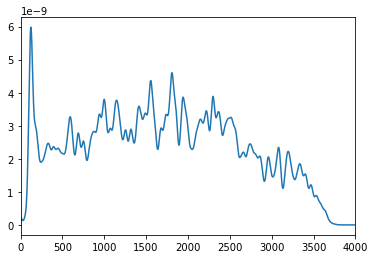

In [125]:
z.iloc[np.random.randint(0,1000),:].plot()

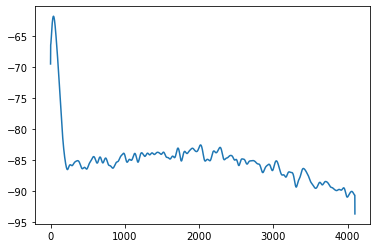

In [94]:
import matplotlib.pyplot as plt
plt.plot(z.values[np.random.randint(0,1000),:])



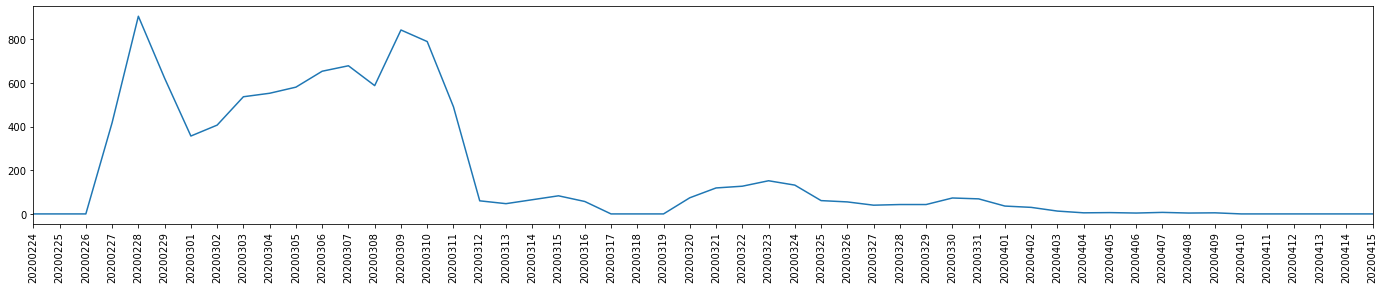

In [140]:
rodr.parse_filenames()
rodr.plot_daterange(start='20200224', end='20200415')